<a href="https://colab.research.google.com/github/JanMeow/ML-cases/blob/main/0823_SAM_Coupling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import image

In [73]:
img_0 = "1qPYq5wf1pE72mN5meuBU6GRatGd6lz78"
img_1 = "1pC3AbQwWg2Ak0Jq1zKGAukIH-1sMViRK"
img_2 = "1uo8C7CrxglnsglbvW_riFrAQiAzbTsWG"
img_3 = "1RqCVsiY0oGUZ0zFUMxG5MyyZgmH7wNJU"

mask_0 = "1wS6o9dar-kaYHHWNH_aOaaQyDpR50RwA"
mask_1 = "1CIvPl0smPgpREoNwiZtodvVGLLSbq8Tf"
mask_2 = "1TfmxxFLD3voLeYtLVomkOoU8o0yy05dx"
mask_3 = "1Mx3ZibAxoF4HcLyYS7zMyWNxMSzn8-vJ"

!gdown --id $img_3 --output window.jpg
!gdown --id $mask_3 --output window_mask.jpg
!gdown --id $img_0 --output window_test.jpg
!gdown --id $img_1 --output window_test2.jpg

train_img = "window.jpg"
train_mask = "window_mask.jpg"
test_img = "window_test.jpg"

test_img2 = 'window_test2.jpg'

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1RqCVsiY0oGUZ0zFUMxG5MyyZgmH7wNJU
To: /content/window.jpg
100% 28.9k/28.9k [00:00<00:00, 56.8MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1Mx3ZibAxoF4HcLyYS7zMyWNxMSzn8-vJ
To: /content/window_mask.jpg
100% 7.43k/7.43k [00:00<00:00, 20.8MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com

# Personalize SAM with one shot (training-free)

In this notebook, we'll illustrate the paper ["Personalize Segment Anything Model with One Shot"](https://arxiv.org/abs/2305.03048), which allows for a Dreambooth-like personalization of the foundational [SAM](https://huggingface.co/docs/transformers/main/model_doc/sam) (segment-anything) model by Meta AI. We'll go over the various steps proposed by the authors in code.

The figure below nicely summarizes the idea. The user provides one example image + corresponding mask, and the PerSAM method allows to directly segment the target concept (like a dog) in new images. This notebook covers the "training-free" approach, where the entire PerSAM model is kept frozen. PerSAM itself only adds about 20 lines of code compared to the original SAM.

<img src="https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/model_doc/persam_overview.jpg"
alt="drawing" width="600"/>

## Set-up environment

First, let's install the 🤗 Transformers library. We install from source here as PerSAM is brand new at the time of writing.

In [3]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 47.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 66.2 MB/s eta 0:00:00


## Load model

Next, we'll load the PerSAM model, which does some minimal modifications to the original [SAM](https://huggingface.co/docs/transformers/main/model_doc/sam) (segment anything) model by Meta AI. In this case, we load the [huge](https://huggingface.co/facebook/sam-vit-huge) variant.

In [4]:
from transformers import AutoProcessor, SamModel
# from transformers import PerSamModel

processor = AutoProcessor.from_pretrained("facebook/sam-vit-huge")
# model = PerSamModel.from_pretrained("facebook/sam-vit-huge")
model = SamModel.from_pretrained("facebook/sam-vit-huge")

## Load reference image and mask

Next, we'll load one reference image and a corresponding segmentation mask.

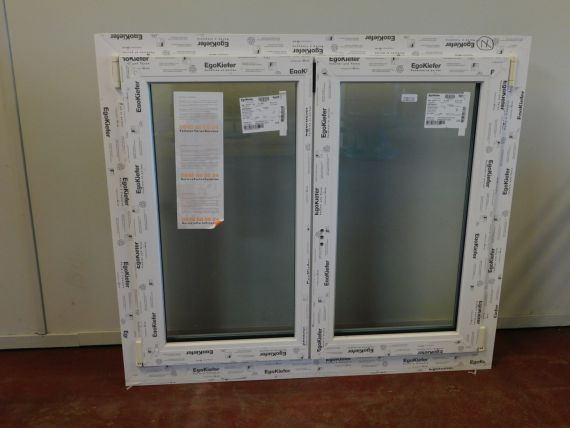

In [5]:
from huggingface_hub import hf_hub_download
from PIL import Image

ref_image = Image.open(train_img).convert("RGB")
ref_image

In [6]:
import cv2
import numpy as np

ref_mask = cv2.imread(train_mask)
ref_mask = cv2.cvtColor(ref_mask, cv2.COLOR_BGR2RGB)
ref_mask[ref_mask < 200] = 0
ref_mask[ref_mask >= 200] = 255
np.unique(ref_mask)

array([  0, 255], dtype=uint8)

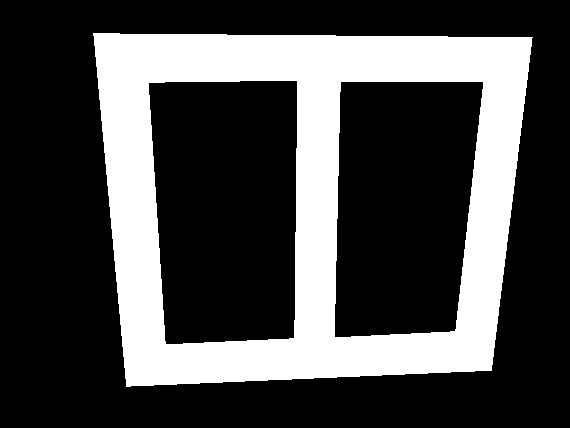

In [7]:
visual_mask = ref_mask.astype(np.uint8)
Image.fromarray(visual_mask)

In [8]:
print(visual_mask.shape)
print(ref_mask.shape)

(428, 570, 3)
(428, 570, 3)


Note: this segmentation mask was obtained with SAM itself.

## Load test image

Next, we load a test image on which we'd like to get a segmentation mask.

The goal will be to segment this new image of a dog, just using the single
(image, mask) pair above as an example.

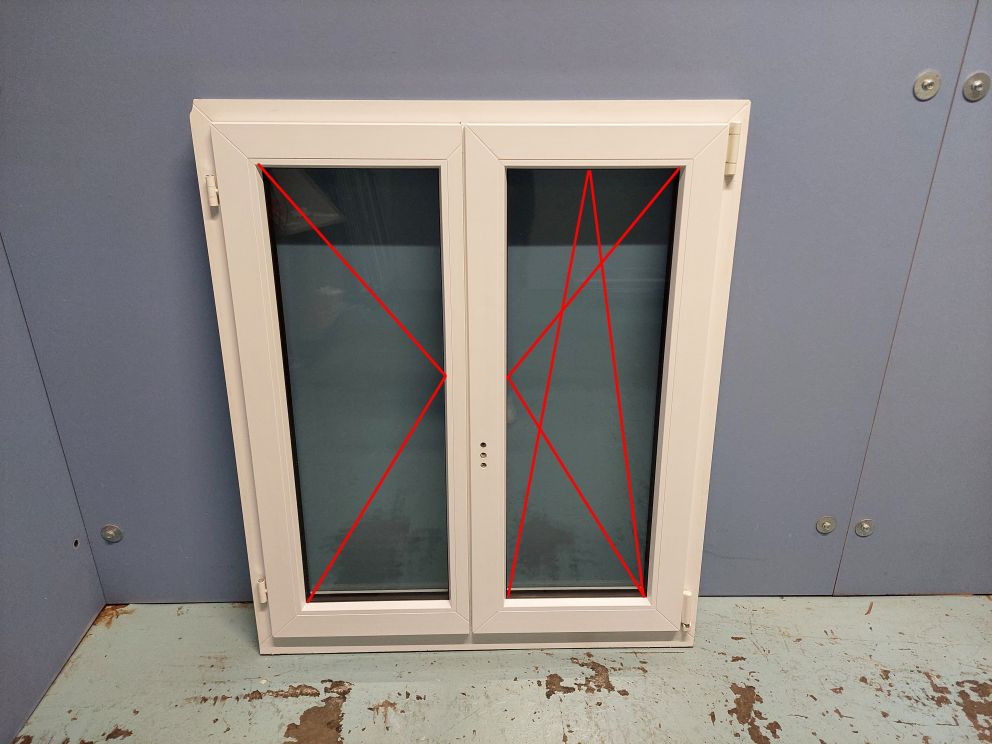

In [9]:
test_image = Image.open(test_img).convert("RGB").convert("RGB")
test_image

## Step 1: get target embedding

The PerSAM [paper](https://arxiv.org/abs/2305.03048) explains in detail the methodology. Here we go over it in code. First, PerSAM calculates a "target embedding", which can be seen as a numerical representation of the target concept (in this case, a dog). The target embedding is obtained by:

1. getting the image features from the reference image using SAM's vision backbone (called `ref_feat` below)
2. using the reference mask to update these features. The reference mask is used to derive the features of pixels within the target visual concept from `ref_feat`, and adopts an average pooling to aggregate its global visual embedding.

In [10]:
pixel_values = processor(images=ref_image, return_tensors="pt").pixel_values
print(pixel_values.shape)

torch.Size([1, 3, 1024, 1024])


In [11]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# Step 1: Image features encoding
with torch.no_grad():
  ref_feat = model.get_image_embeddings(pixel_values.to(device))
  ref_feat = ref_feat.squeeze().permute(1, 2, 0)

In [12]:
import numpy as np
import torch.nn.functional as F
from torchvision.transforms.functional import resize, to_pil_image
import torch
from typing import Tuple

def get_preprocess_shape(oldh: int, oldw: int, long_side_length: int) -> Tuple[int, int]:
    """
    Calculate the output size given the input size and target long side length.
    """

    # Calculate the scaling ratio for the long side length
    scale = long_side_length * 1.0 / max(oldh, oldw)

    # Scale the original height and width by the ratio to get the new height and width
    newh, neww = oldh * scale, oldw * scale

    # Round the new width to the nearest integer
    neww = int(neww + 0.5)

    # Round the new height to the nearest integer
    newh = int(newh + 0.5)

    # Return the new height and width as output
    return (newh, neww)


def preprocess(x: torch.Tensor, pixel_mean=[123.675, 116.28, 103.53], pixel_std=[58.395, 57.12, 57.375], img_size=1024) -> torch.Tensor:
    """
    Normalize image pixel values and pad the input image to make it a square of the specified size.

    Parameters:
        x (torch.Tensor): PyTorch tensor representation of the input image.
        pixel_mean (list): Pixel mean values for normalization. Default is [123.675, 116.28, 103.53].
        pixel_std (list): Pixel standard deviation values for normalization. Default is [58.395, 57.12, 57.375].
        img_size (int): Target square size after padding. Default is 1024.

    Returns:
        torch.Tensor: Preprocessed image as a PyTorch tensor.
    """

    # Convert pixel_mean and pixel_std to PyTorch tensors and reshape for normalization
    pixel_mean = torch.Tensor(pixel_mean).view(-1, 1, 1)
    pixel_std = torch.Tensor(pixel_std).view(-1, 1, 1)

    # Normalize image pixels using pixel_mean and pixel_std
    x = (x - pixel_mean) / pixel_std

    # Get the height and width of the input image
    h, w = x.shape[-2:]

    # Calculate the padding needed to make the image a square
    padh = img_size - h
    padw = img_size - w

    # Pad the image to make it a square
    x = F.pad(x, (0, padw, 0, padh))

    return x


def prepare_mask(image, target_length=1024):
    """
    Function to prepare the mask.

    Parameters:
        image (np.array): NumPy array representation of the input image.
        target_length (int): Target mask length. Default is 1024.

    Returns:
        torch.Tensor: Preprocessed mask as a PyTorch tensor.
    """

    # Get the size of the input image
    image_height, image_width = image.shape[0], image.shape[1]

    # Calculate the size of the processed mask
    target_size = get_preprocess_shape(image_height, image_width, target_length)

    # Resize the mask to the specified size
    mask = np.array(resize(to_pil_image(image), target_size))

    # Convert the mask to a PyTorch tensor
    input_mask = torch.as_tensor(mask)

    # Rearrange the channel dimension of the mask and add a batch dimension
    input_mask = input_mask.permute(2, 0, 1).contiguous()[None, :, :, :]

    # Preprocess the mask
    input_mask = preprocess(input_mask)

    return input_mask


In [13]:
a = prepare_mask(ref_mask)
b = F.interpolate(a, size=ref_feat.shape[0: 2], mode="bilinear")
print(ref_feat.shape)
print(a.shape)
print(b.shape)

torch.Size([64, 64, 256])
torch.Size([1, 3, 1024, 1024])
torch.Size([1, 3, 64, 64])


In [14]:
# Step 2: interpolate reference mask
ref_mask = prepare_mask(ref_mask)
ref_mask = F.interpolate(ref_mask, size=ref_feat.shape[0: 2], mode="bilinear")
ref_mask = ref_mask.squeeze()[0]

# Step 3: Target feature extraction
target_feat = ref_feat[ref_mask > 0]
target_embedding = target_feat.mean(0).unsqueeze(0)
target_feat = target_embedding / target_embedding.norm(dim=-1, keepdim=True)
target_embedding = target_embedding.unsqueeze(0)
print(target_embedding.shape)

torch.Size([1, 1, 256])


## Step 2: calculate cosine similarity

Next, using this target embedding, we can acquire a location confidence map of where the target concept is present in the test image by calculating the cosine similarity between the target embedding and the image features of the test image.

In [15]:
# prepare test image for the model
inputs = processor(images=test_image, return_tensors="pt").to(device)
pixel_values = inputs.pixel_values

# image feature encoding
with torch.no_grad():
  test_feat = model.get_image_embeddings(pixel_values).squeeze()

In [16]:
# Cosine similarity
num_channels, height, width = test_feat.shape
test_feat = test_feat / test_feat.norm(dim=0, keepdim=True)
test_feat_reshaped = test_feat.reshape(num_channels, height * width)
sim = target_feat @ test_feat_reshaped

sim = sim.reshape(1, 1, height, width)
sim = F.interpolate(sim, scale_factor=4, mode="bilinear")

In [17]:
sim = processor.post_process_masks(sim.unsqueeze(1), original_sizes=inputs["original_sizes"].tolist(), reshaped_input_sizes=inputs["reshaped_input_sizes"].tolist(),
                                   binarize=False)
sim = sim[0].squeeze()

## Step 3: obtain location priors

The next step is getting good "prompts" for SAM in the form of coordinates (point locations). These prompts are also called "location priors", which indicate where the target concept (in this case, a dog) might be or not be at all in the test image.

The PerSAM authors select two pixel coordinates with the highest and lowest similarity values. The former represents the most likely foreground position of the target object, while the latter inversely indicates the background.

As we now, SAM is very good at generating a mask given a "prompt". So we basically come up with very good "prompts" to make sure SAM will be able to segment the dog in the new image.

In [18]:
def point_selection(mask_sim, topk=1):
    # Top-1 point selection
    w, h = mask_sim.shape
    topk_xy = mask_sim.flatten(0).topk(topk)[1]
    topk_x = (topk_xy // h).unsqueeze(0)
    topk_y = (topk_xy - topk_x * h)
    topk_xy = torch.cat((topk_y, topk_x), dim=0).permute(1, 0)
    topk_label = np.array([1] * topk)
    topk_xy = topk_xy.cpu().numpy()

    # Top-last point selection
    last_xy = mask_sim.flatten(0).topk(topk, largest=False)[1]
    last_x = (last_xy // h).unsqueeze(0)
    last_y = (last_xy - last_x * h)
    last_xy = torch.cat((last_y, last_x), dim=0).permute(1, 0)
    last_label = np.array([0] * topk)
    last_xy = last_xy.cpu().numpy()

    return topk_xy, topk_label, last_xy, last_label

# Positive-negative location prior
topk_xy_i, topk_label_i, last_xy_i, last_label_i = point_selection(sim, topk=1)
topk_xy = np.concatenate([topk_xy_i, last_xy_i], axis=0)
topk_label = np.concatenate([topk_label_i, last_label_i], axis=0)

# Obtain the target guidance for cross-attention layers
sim = (sim - sim.mean()) / torch.std(sim)
sim = F.interpolate(sim.unsqueeze(0).unsqueeze(0), size=(64, 64), mode="bilinear")
attention_similarity = sim.sigmoid_().unsqueeze(0).flatten(3)
print("Shape of attention_similarity:", attention_similarity.shape)
print("First values of attention_similarity:", attention_similarity[0,0,:3,:3])

Shape of attention_similarity: torch.Size([1, 1, 1, 4096])
First values of attention_similarity: tensor([[0.3632, 0.3523, 0.3196]], device='cuda:0')


In [19]:
test_feat[0,:3,:3]

tensor([[-0.0605, -0.0480, -0.0430],
        [-0.0621, -0.0501, -0.0432],
        [-0.0871, -0.0914, -0.0610]], device='cuda:0')

In [20]:
test_feat[0,:3,:3]

tensor([[-0.0605, -0.0480, -0.0430],
        [-0.0621, -0.0501, -0.0432],
        [-0.0871, -0.0914, -0.0610]], device='cuda:0')

## Step 4: first step prediction

Next, we can prompt SAM to generate a mask for the target concept (the dog) in the test image, using the prompts we prepared below. Interestingly here is that the authors add "Target-guided Attention" and "Target-semantic prompting" to the decoder. This allows for more explicit guidance to the cross-attention mechanisms in SAM’s decoder, which concentrates feature aggregation within foreground target regions. This ultimately leads to more accurate masks when personalizing SAM in a training-free manner.

In [21]:
# prepare test image and prompts for the model
inputs = processor(test_image, input_points=[topk_xy.tolist()], input_labels=[topk_label.tolist()], return_tensors="pt").to(device)
for k,v in inputs.items():
  print(k,v.shape)

pixel_values torch.Size([1, 3, 1024, 1024])
original_sizes torch.Size([1, 2])
reshaped_input_sizes torch.Size([1, 2])
input_points torch.Size([1, 1, 2, 2])
input_labels torch.Size([1, 1, 2])


In [22]:
attention_similarity.shape

torch.Size([1, 1, 1, 4096])

In [23]:
target_embedding.shape

torch.Size([1, 1, 256])

In [24]:
# First-step prediction
with torch.no_grad():
  outputs = model(
      input_points=inputs.input_points,
      input_labels=inputs.input_labels,
      image_embeddings=test_feat.unsqueeze(0),
      multimask_output=False,
      attention_similarity=attention_similarity,  # Target-guided Attention
      target_embedding=target_embedding  # Target-semantic Prompting
  )
  best_idx = 0

## Step 5: 2-step cascaded post-refinement

Finally, the authors propose to further improve the segmentation mask using cascaded post-refinement. The initial mask (predicted above) might include some rough edges and isolated noises in the background. The authors propose to iteratively feed the mask back into SAM’s decoder for a two-step post-processing.

In [25]:
# Cascaded Post-refinement-1
with torch.no_grad():
  outputs_1 = model(
              input_points=inputs.input_points,
              input_labels=inputs.input_labels,
              input_masks=outputs.pred_masks.squeeze(1)[best_idx: best_idx + 1, :, :],
              image_embeddings=test_feat.unsqueeze(0),
              multimask_output=True)

In [26]:
# Cascaded Post-refinement-2
masks = processor.image_processor.post_process_masks(outputs_1.pred_masks.cpu(),
                                                     inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu())[0].squeeze().numpy()

best_idx = torch.argmax(outputs_1.iou_scores).item()
y, x = np.nonzero(masks[best_idx])
x_min = x.min()
x_max = x.max()
y_min = y.min()
y_max = y.max()
input_boxes = [[[x_min, y_min, x_max, y_max]]]

inputs = processor(test_image, input_points=[topk_xy.tolist()], input_labels=[topk_label.tolist()], input_boxes=input_boxes,
                   return_tensors="pt").to(device)

final_outputs = model(
    input_points=inputs.input_points,
    input_labels=inputs.input_labels,
    input_boxes=inputs.input_boxes,
    input_masks=outputs_1.pred_masks.squeeze(1)[:,best_idx: best_idx + 1, :, :],
    image_embeddings=test_feat.unsqueeze(0),
    multimask_output=True)

In [27]:
masks = processor.image_processor.post_process_masks(final_outputs.pred_masks.cpu(),
     inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu())[0].squeeze().numpy()

## Visualize mask

We can visualize the predicted mask on top of our test image:

(-0.5, 991.5, 743.5, -0.5)

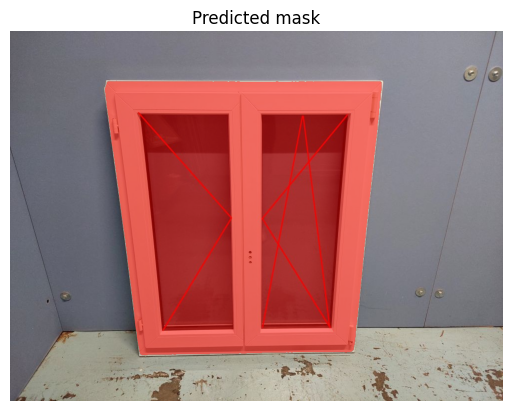

In [28]:
import matplotlib.pyplot as plt

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([255, 0, 0, 0.5])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

fig, axes = plt.subplots()

best_idx = torch.argmax(final_outputs.iou_scores).item()
axes.imshow(np.array(test_image))
show_mask(masks[best_idx], axes)
axes.title.set_text(f"Predicted mask")
axes.axis("off")

In [29]:
mask_inverted = masks[best_idx] == False
mask_inverted.shape[-2:]

(744, 992)

In [30]:
np.array(test_image).shape[0]

744

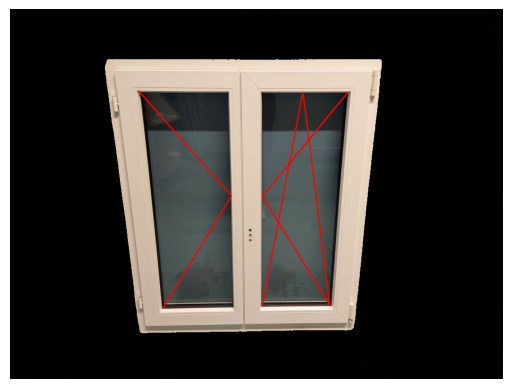

In [31]:
import matplotlib.pyplot as plt
import cv2
from pathlib import Path

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([0, 0, 0, 0.999])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

fig, axes = plt.subplots()
sizes = np.array(test_image).shape

best_idx = torch.argmax(final_outputs.iou_scores).item()
axes.imshow(np.array(test_image))
show_mask(mask_inverted, axes)
axes.axis("off")


plt.savefig('./window_perSAM.jpg')

##0. SAM

In [32]:
##0.  Environment Set-up
import torch
import torchvision
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())
import sys
!{sys.executable} -m pip install opencv-python matplotlib
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

!mkdir images
!wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg


!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

PyTorch version: 2.0.1+cu118
Torchvision version: 0.15.2+cu118
CUDA is available: True
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-ktd3j416
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-ktd3j416
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36586 sha256=e8670229794991f78befe7723929a38653118c3be8f2d0e9fb6297cb886c5b5f
  Stored in directory: /tmp/pip-ephem-wheel-cache-67xfkm40/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything
--2023-08-25 07:25:45--  https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com

In [33]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [34]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

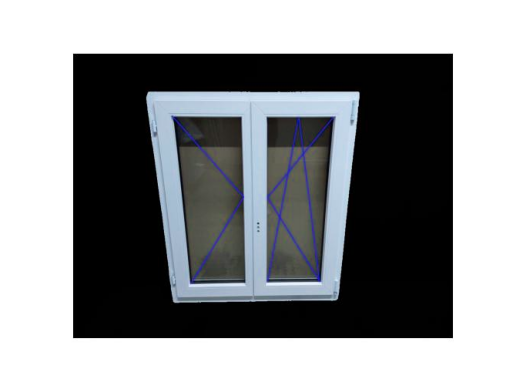

In [35]:
image = cv2.imread('./window_perSAM.jpg')
plt.figure()
plt.imshow(image)
plt.axis('off')

plt.show()

##2. Automatic Mask Generation

In [36]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

In [37]:
masks = mask_generator.generate(image)

In [39]:
print(len(masks))
print(masks[0].keys())

10
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


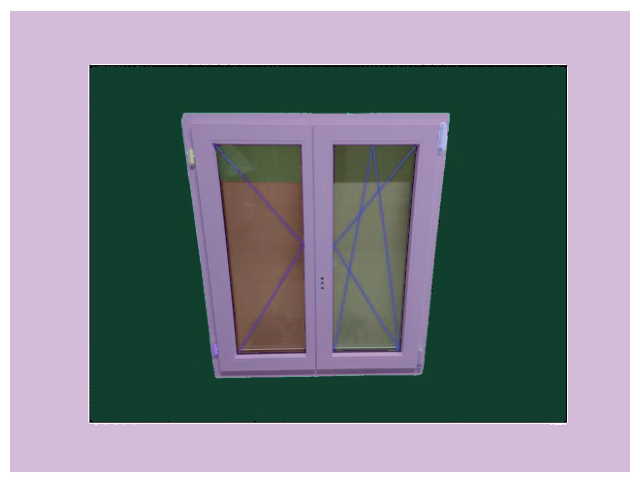

In [40]:
plt.figure(figsize=(8,8))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show()

#3. Selecting Object with SAM and prompt

In [41]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

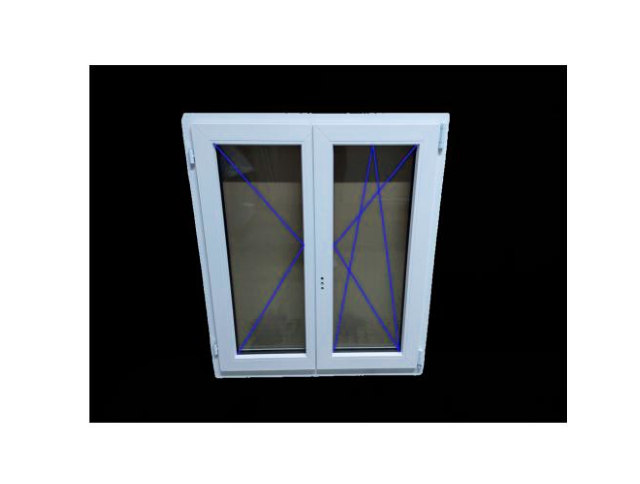

In [42]:
plt.figure(figsize=(8,8))
plt.imshow(image)
plt.axis('off')
plt.show()

In [43]:
predictor.set_image(image)

In [44]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

In [85]:
input_point = np.array([[190, 120], [270,250], [370,250]])
input_label = np.array([1,1,0,0])

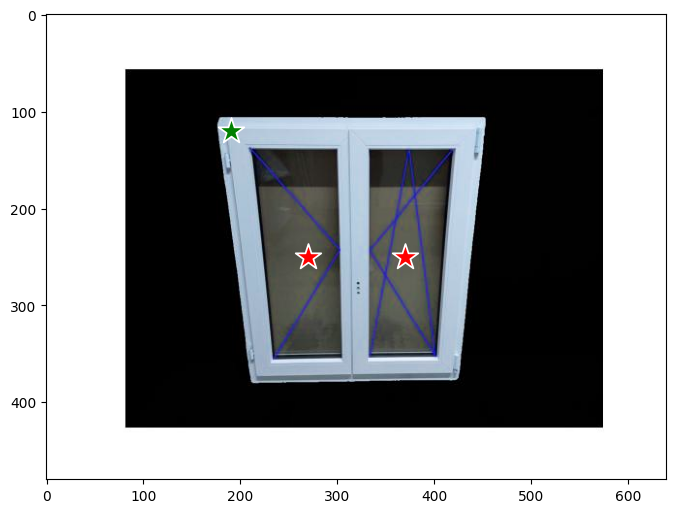

In [86]:
plt.figure(figsize=(8,8))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()

In [87]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

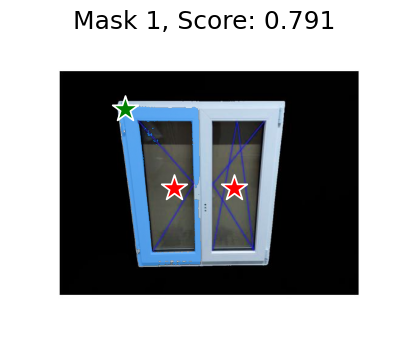

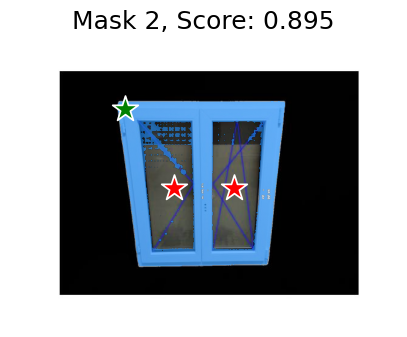

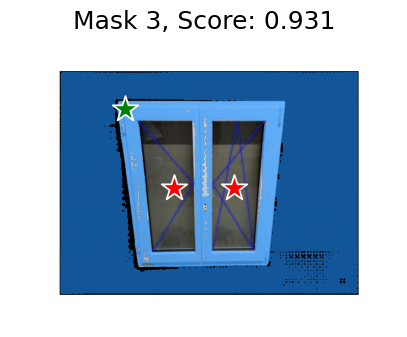

In [88]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(5,5))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()

#Specifying a specific object with a box

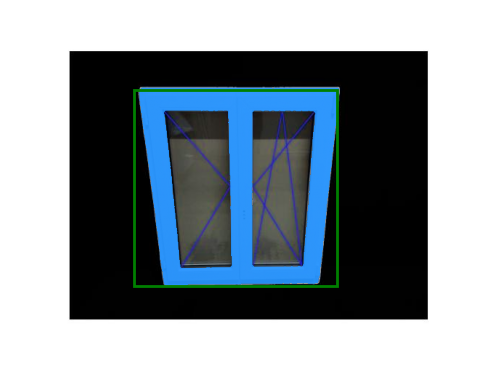

In [116]:
input_point = np.array([[270,250], [370,250]])
input_label = np.array([0,0])

#input_box format is in x1y1 x2y2
input_box = np.array([170, 110, 450, 380])

masks, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    box=input_box[None, :],
    multimask_output=False,
)

plt.figure(figsize=(6, 6))
plt.imshow(image)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
plt.axis('off')
plt.show()

In [113]:
masks.shape

(480, 640)

In [120]:
masks[0].shape + (4,)

(480, 640, 4)

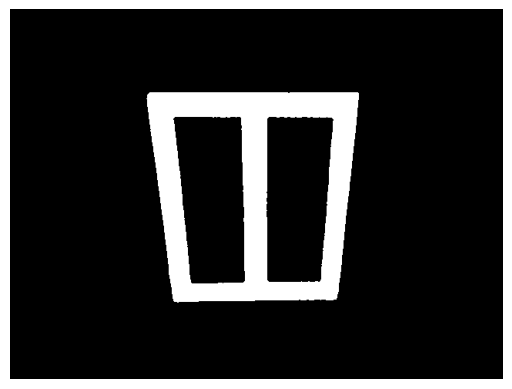

In [125]:
import matplotlib.pyplot as plt
import numpy as np

# Invert the segmentation mask
inverted_masks = 1 - masks

# Create a black canvas
black_canvas = np.zeros(masks[0].shape + (4,), dtype=np.float32)

# Set the alpha channel of the black canvas using the inverted mask values
black_canvas[..., 3] = inverted_masks  # Use inverted mask values as alpha channel

# Display the black canvas with the inverted segmentation mask
plt.imshow(black_canvas, cmap='gray')  # Use 'gray' colormap to show black and white
plt.axis('off')

#Saving the fig before showing it *important

plt.show()

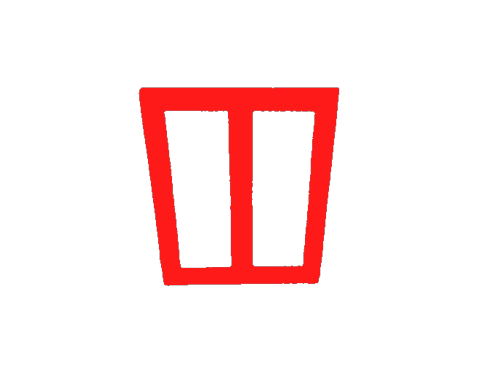

In [140]:
def show_mask(mask, ax):
    color = np.array([255, 0,0, 0.9])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image, cmap = 'gray')


plt.figure(figsize=(6, 6))
show_mask(masks[0], plt.gca())
plt.axis('off')
plt.savefig('./window_SAMCouple.jpg')

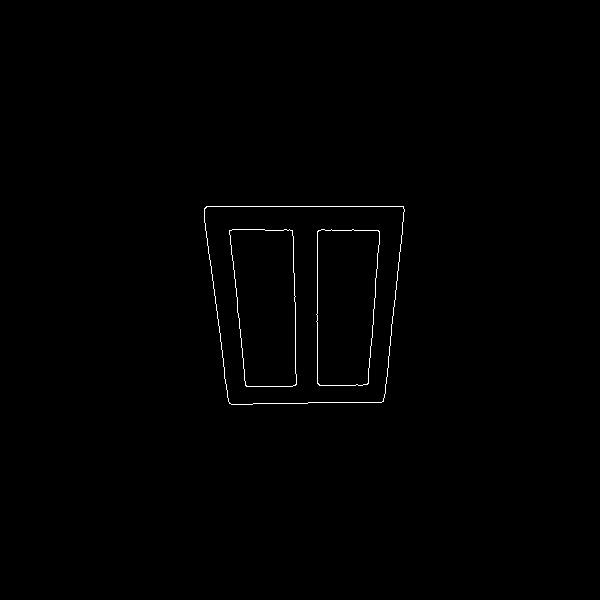

In [141]:
import cv2
from google.colab.patches import cv2_imshow


from PIL import Image
from pathlib import Path
SAM_masks = Path('./window_SAMCouple.jpg')
ref_image = Image.open(SAM_masks)

numpy_array = np.array(ref_image)

#convert to grayscale
img_gray =cv2.cvtColor(numpy_array, cv2.COLOR_BGR2GRAY)
#Blur the image for better edge detection
img_blur = cv2.GaussianBlur(img_gray, (3,3),0)

# Canny Edge Detection
edges = cv2.Canny(image=img_blur, threshold1=100, threshold2=200) # Canny Edge Detection
cv2_imshow(edges)

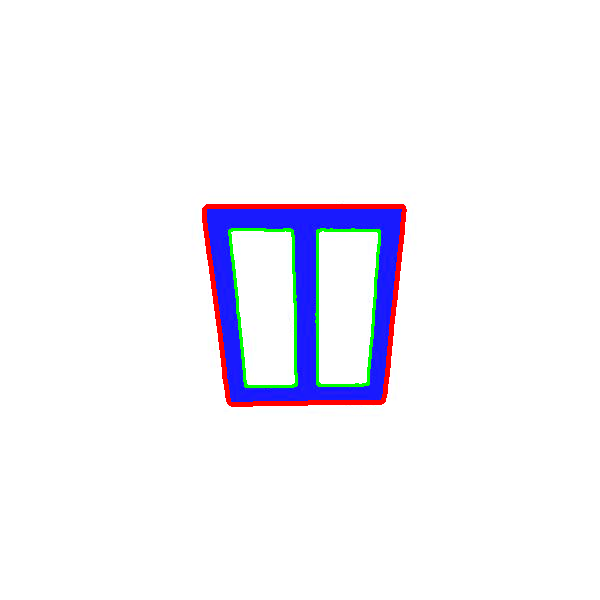

In [142]:
import cv2
import numpy as np

# Load the image
img_blur = cv2.GaussianBlur(img_gray, (3,3),0)
edges = cv2.Canny(image=img_blur, threshold1=100, threshold2=200)
original_img = np.array(ref_image)

# Find external contours in the image
ex_contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
in_contours, _ = cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)


# Convert the contours to the desired format
ex_vertices = []
in_vertices = []
for contour in ex_contours:
    vertices = contour.reshape(-1, 2).tolist()
    ex_vertices.append(vertices)

for contour in in_contours:
  vertices = contour.reshape(-1, 2).tolist()
  in_vertices.append(vertices)

# Draw contours on the original image
cv2.drawContours(original_img, in_contours, -1, (0, 255, 0), 2)
cv2.drawContours(original_img, ex_contours, -1, (0, 0, 255), 3)


# Display the image with contours
cv2_imshow(original_img)

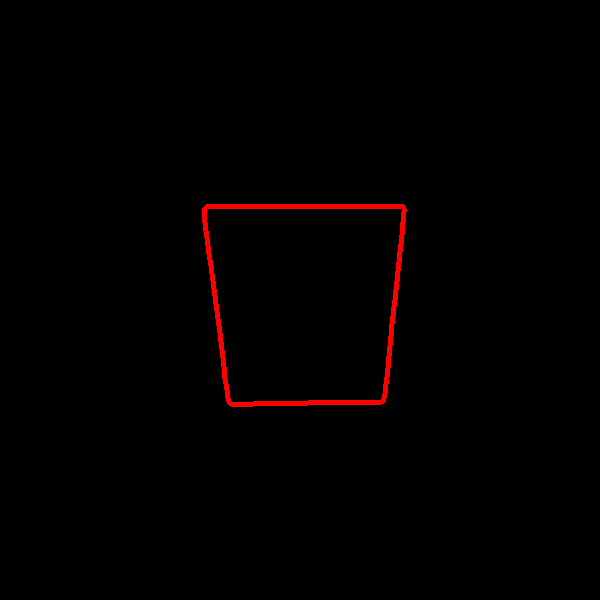

In [144]:
import cv2
import numpy as np

# Load the image
img_blur = cv2.GaussianBlur(img_gray, (3, 3), 0)
edges = cv2.Canny(image=img_blur, threshold1=100, threshold2=200)

# Find external contours in the image
ex_contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
in_contours, _ = cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

# Create a black canvas
height, width = edges.shape
black_canvas = np.zeros((height, width,3), dtype=np.uint8)

# Draw contours on the black canvas
cv2.drawContours(black_canvas, ex_contours, -1, (0, 0, 255), 3)

# Save the image
cv2_imshow(black_canvas)

In [145]:
gray_img = cv2.cvtColor(black_canvas, cv2.COLOR_BGR2GRAY)
corners = cv2.goodFeaturesToTrack(gray_img, 4, 0.5, 50)
corners = np.reshape(a = corners, newshape = (4,2))

In [146]:
gray_img = cv2.cvtColor(black_canvas, cv2.COLOR_BGR2GRAY)
corners = cv2.goodFeaturesToTrack(gray_img, 4, 0.5, 50)
corners = np.reshape(a = corners, newshape = (4,2))

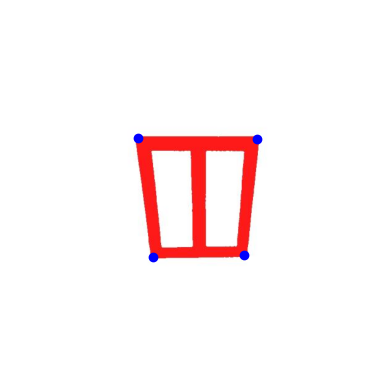

In [149]:
import numpy as np
import matplotlib.pyplot as plt
import cv2


# Separate the x and y coordinates

x_coords = corners[:, 0]
y_coords = corners[:, 1]

# Plot the image
plt.imshow(ref_image)

# Plot the points as red dots
plt.scatter(x_coords, y_coords, color='blue', marker='o')
plt.axis('off')

# Show the plot
plt.show()

In [154]:
corners

array([[400., 210.],
       [231., 401.],
       [207., 209.],
       [380., 399.]], dtype=float32)

In [166]:
# Rearragning the corners in to ([bottomLeft, bottomRight, topRight, topLeft])

import numpy as np


# Calculate the center of the image
center = np.mean(corners, axis=0)

# Determine each corner's position relative to the center
relative_positions = corners - center

# Sort corners based on their relative positions
sorted_indices = np.argsort(np.arctan2(relative_positions[:, 0], relative_positions[:, 1]))

# Rearrange corners
rearranged_corners = corners[sorted_indices]

corners = rearranged_corners


In [167]:
#Perspective transformation
import numpy
import cv2

# perspective_corners = np.array([top_left, bottom_left, bottom_right, top_right],  dtype=np.float32)
perspective_corners = corners

#Actual dimension
actual_width = 200
actual_height = 150

# Front elevation coordinates of the rectangle (4 corners)
front_elevation_corners = np.array([(0,0), (0, actual_height), (actual_width, actual_height), (actual_width, 0)], dtype=np.float32)


#Transformation Matrix
transformation_matrix = cv2.getPerspectiveTransform(perspective_corners, front_elevation_corners)

In [168]:
#Get all white pixel from Canny Edges

edges = cv2.Canny(image=img_blur, threshold1=100, threshold2=200) # Canny Edge Detection
edges_array = np.array(edges, dtype=np.uint8)  # Convert to uint8

# Create a mask of all white pixels in the edges image
white_pixel_mask = edges_array == 255

# Get the positions of white pixels
white_pixel_positions = np.argwhere(white_pixel_mask)

In [169]:
# flipping width and height
white_pixel_positions = np.column_stack((white_pixel_positions[:,1], white_pixel_positions[:,0]))

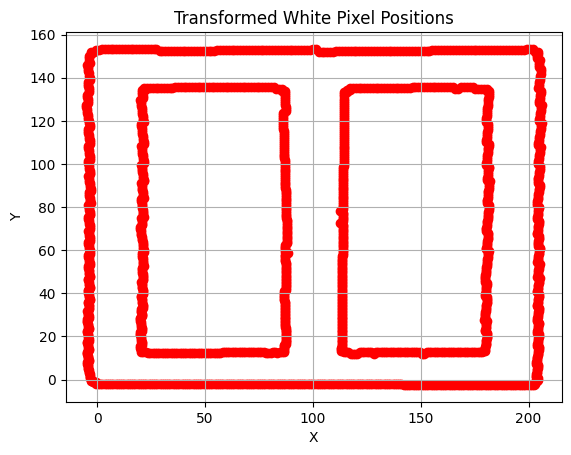

In [170]:
# Apply the transformation to your pixel coordinates
transformed_positions = np.dot(transformation_matrix, np.column_stack((white_pixel_positions, np.ones(white_pixel_positions.shape[0]))).T)

# Convert back to homogeneous coordinates
transformed_positions /= transformed_positions[2, :]

# Plot the transformed white pixel positions
plt.scatter(transformed_positions[0, :], transformed_positions[1, :], color='red', marker='o')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Transformed White Pixel Positions')
plt.grid()
plt.axis('equal')
plt.show()